step 1: setup import

In [2]:
!pip install mne numpy pandas matplotlib scikit-learn

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

Step 2: Load EEG Data

Extracting EDF parameters from C:\Users\HP\sample_data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168575  =      0.000 ...  1316.992 secs...
Using matplotlib as 2D backend.


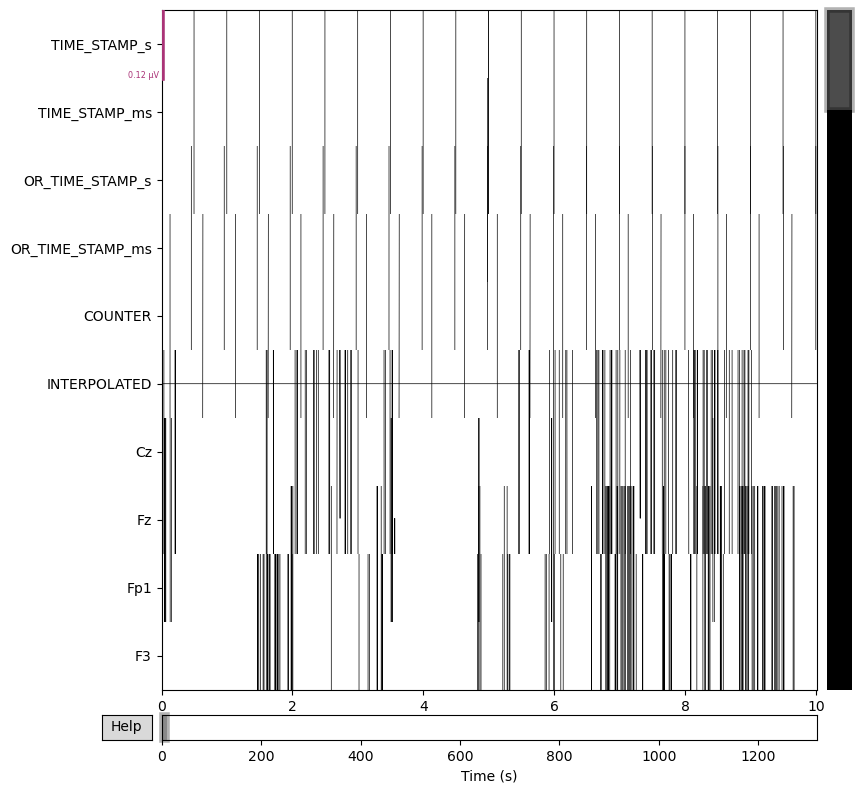

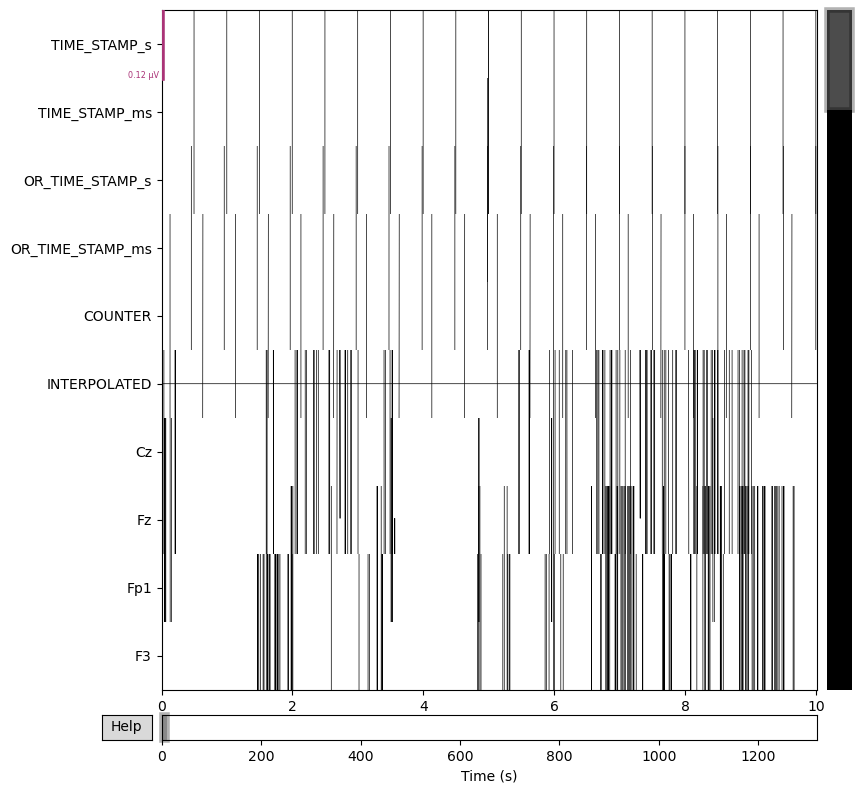

In [4]:
raw = mne.io.read_raw_edf("sample_data.edf", preload=True)
raw.plot(n_channels=10, scalings='auto')

Step 3: EEG Signal Preprocessing

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


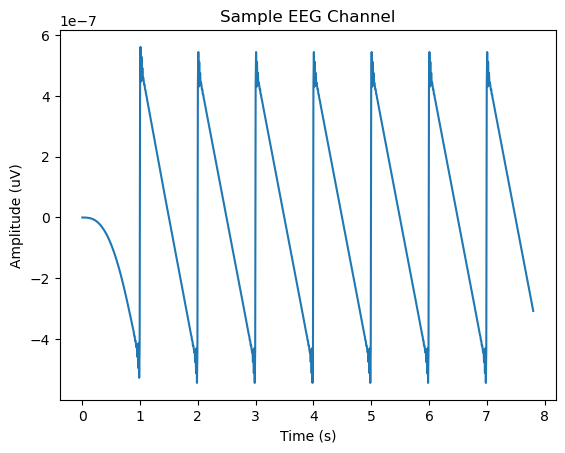

In [6]:
# Filter the signal (1-50 Hz)
raw.filter(1., 50.)

# Get EEG data and convert to numpy
eeg_data, times = raw.get_data(return_times=True)

# Visualize a channel
plt.plot(times[:1000], eeg_data[0, :1000])
plt.title("Sample EEG Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.show()

Step 4: Feature Extraction

In [8]:
def extract_features(eeg_data, window_size=256):
    features = []
    for i in range(0, eeg_data.shape[1] - window_size, window_size):
        window = eeg_data[:, i:i+window_size]
        feat = np.concatenate([
            np.mean(window, axis=1),
            np.std(window, axis=1),
            np.max(window, axis=1),
            np.min(window, axis=1)
        ])
        features.append(feat)
    return np.array(features)

X = extract_features(eeg_data)
print("Shape of features:", X.shape)

# Dummy labels: 0 = normal, 1 = stressed/pain
y = np.zeros(X.shape[0])
y[:100] = 1


Shape of features: (658, 272)


Step 5: AI Model: Classification

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       170
         1.0       1.00      0.68      0.81        28

    accuracy                           0.95       198
   macro avg       0.97      0.84      0.89       198
weighted avg       0.96      0.95      0.95       198



Step 6: Recommendation Based on Prediction

In [12]:
def get_recommendation(prediction):
    if prediction == 0:
        return "Continue therapy. No abnormal signals."
    else:
        return "Suggest VR mirror therapy and relaxation training."

# Predict on a new EEG segment
new_input = X_test[0].reshape(1, -1)
pred = model.predict(new_input)[0]
print("EEG Analysis:", get_recommendation(pred))


EEG Analysis: Continue therapy. No abnormal signals.
